In [1]:
#!pip install albumentations
#!pip install imgaug

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm 
import time
import os
from PIL import Image
import cv2 
import re

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
#from albumentations.augmentations.transforms import HorizontalFlip,VerticalFlip

% matplotlib inline

## Masha's dataloader

In [4]:
class TwinPairsDataset(Dataset):
    def __init__(self, dataroot, df_pairs, df_views, transform, keypoints=False):
        '''
        dataroot: path to folder with items
        df_pairs: pd dataframe containing pairs of ids and a correspodind label:
                    'Same', 'Fraternal', 'Identical', 'UnknownTwinType',
                    'IdenticalMirror', 'Sibling', 'IdenticalTriplet'
        df_views: pd dataframe containing list of available for each id in the dataset                    
        transform: torchvision transform
        '''
        self.dataroot = dataroot
        self.df_pairs = df_pairs
        self.df_views = df_views
        self.transform = transform
        self.keypoints = keypoints
        
    def __getitem__(self, index):
        sample={}
        
        id_1, id_2  = self.df_pairs.iloc[index][['id_1', 'id_2']].values
        #print(id_1, id_2)
        id_1 = str(id_1)
        id_2 = str(id_2)
        label = int(self.df_pairs.iloc[index].label=='Same')
        #print('Same' if label==1 else 'Twin')
        if id_1==id_2:
            view_1 = np.random.choice(self.df_views.loc[id_1]['filename'], size=1, replace=False)[0] 
            #print(view_1)
            view_2=view_1
        else:
            view_1 = np.random.choice(self.df_views.loc[id_1]['filename'])
            view_2 = np.random.choice(self.df_views.loc[id_2]['filename'])

        path_1 = os.path.join(self.dataroot, id_1, view_1)
        path_2 = os.path.join(self.dataroot, id_2, view_2)
        
        img_1 = Image.open(path_1)
        img_2 = Image.open(path_2)
        #print(view_1)
        #print(view_2)
        if self.keypoints:
            df_keypoints=pd.read_csv(self.dataroot+'/df/aligned_landmarks.csv')
            df_flip_keypoints=pd.read_csv(self.dataroot+'/df/aligned_FLIP_landmarks.csv')
            
            if id_1==id_2:
                keypoints_1 = df_keypoints[view_1].values
                keypoints_1=np.array([ [int(t[1:-1].split(', ')[0]),int(t[1:-1].split(', ')[1])] for t in keypoints_1])
                keypoints_2 = df_flip_keypoints[view_2].values
                keypoints_2=np.array([ [int(t[1:-1].split(', ')[0]),int(t[1:-1].split(', ')[1])] for t in keypoints_2])
                
            else:
                keypoints_1 = df_keypoints[view_1].values
                keypoints_2 = df_keypoints[view_2].values
                keypoints_1=np.array([ [int(t[1:-1].split(', ')[0]),int(t[1:-1].split(', ')[1])] for t in keypoints_1])
                keypoints_2=np.array([ [int(t[1:-1].split(', ')[0]),int(t[1:-1].split(', ')[1])] for t in keypoints_2])
            sample['keypoints_1'] = keypoints_1
            sample['keypoints_2'] = keypoints_2
        
        if label==1:
            img_1 = self.transform['twin'](img_1)
            img_2 = self.transform['same'](img_2)
        else:
            img_1 = self.transform['twin'](img_1)
            img_2 = self.transform['twin'](img_2)
            
        sample['img_1']=img_1
        sample['img_2']=img_2
        sample['label']=label
        
        return sample
    
    def __len__(self):
        return self.df_pairs.shape[0]

In [5]:
data_transform ={
    'same': transforms.Compose([
            transforms.CenterCrop(256),
            transforms.RandomHorizontalFlip(p=1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'twin': transforms.Compose([
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
                }

In [33]:
views = pd.read_csv('/home/khurram/DL_skoltech/Skoltech_DL_2019/Project/Twins/twins_aligned_cropped_resized/df/views.csv', index_col=0)
views.index = views.index.astype(str)
views.filename = views.filename.apply(eval)

# pairs including 50% of same identities
pairs = pd.read_csv('/home/khurram/DL_skoltech/Skoltech_DL_2019/Project/Twins/twins_aligned_cropped_resized/pairs_train.csv')

direct='/home/khurram/DL_skoltech/Skoltech_DL_2019/Project/Twins/twins_aligned_cropped_resized/'

In [34]:
dataset = TwinPairsDataset(direct, pairs, views,transform=data_transform, keypoints=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


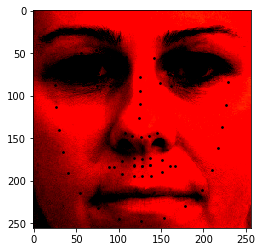

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


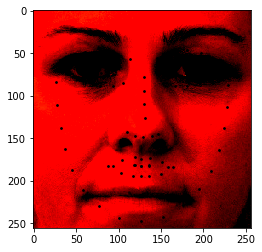

In [35]:
idx = 119

sample = dataset[idx]
std=sample['img_1'].numpy().std()
mean=sample['img_1'].numpy().mean()
plt.imshow(sample['img_1'].numpy().transpose(1,2,0)*std+mean)
kp = sample['keypoints_1']
plt.scatter(kp[:,0], kp[:,1], s=3,color='black')
plt.show()

std=sample['img_2'].numpy().std()
mean=sample['img_2'].numpy().mean()
plt.imshow(sample['img_2'].numpy().transpose(1,2,0)*std+mean)
kp = sample['keypoints_2']
plt.scatter(kp[:,0], kp[:,1], s=3,color='black')

#kp = sample['keypoints_1']
#plt.scatter(kp[:,0], kp[:,1], s=3,color='green')
#plt.show()

### Heatmap

In [104]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [105]:
dataset = TwinPairsDataset(direct, pairs, views,transform=data_transform, keypoints=True)

In [107]:
def gaussian_k(x0,y0,sigma, width, height):
        """ Make a square gaussian kernel centered at (x0, y0) with sigma as SD.
        """
        x = np.arange(0, width, 1, float) ## (width,)
        y = np.arange(0, height, 1, float)[:, np.newaxis] ## (height,1)
        #print(x0)
        #x=x-x0
        #print(x.shape)
        return np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))

def generate_hm(height, width ,landmarks,s=3):
        """ Generate a full Heap Map for every landmarks in an array
        Args:
            height    : The height of Heat Map (the height of target output)
            width     : The width  of Heat Map (the width of target output)
            joints    : [(x1,y1),(x2,y2)...] containing landmarks
            maxlenght : Lenght of the Bounding Box
        """
        Nlandmarks = len(landmarks)
        hm = np.zeros((height, width, Nlandmarks), dtype = np.float32)
        for i in range(Nlandmarks):
            if not np.array_equal(landmarks[i], [-1,-1]):
             
                hm[:,:,i] = gaussian_k(landmarks[i][0],
                                        landmarks[i][1],
                                        s,height, width)
            else:
                hm[:,:,i] = np.zeros((height,width))
        return hm
def heatmap(sample):
    '''
    sample - one element(one pair photos) from dataloader
    '''
    img1=sample['img_1']
    img2=sample['img_2']
    sigma=np.mean(np.linalg.norm(sample['keypoints_1']-sample['keypoints_2'],axis=1))
    hm1=generate_hm(256,256,T['keypoints_1'],s=sigma)
    hm2=generate_hm(256,256,T['keypoints_2'],s=sigma)
    heatmap=np.max(hm1,axis=2)*np.max(hm2,axis=2)
    #plt.imshow(heatmap)
    #plt.show()
    return torch.Tensor([heatmap,heatmap,heatmap]).float()

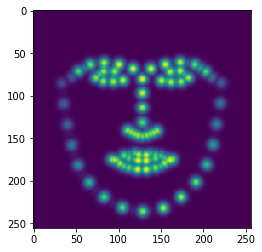

"\nfor i in range(1,pairs.shape[0]):\n    T=dataset[i]\n    \n    if T['label']==0:\n        print(T['label'])\n        h=heatmap(T)\n        time.sleep(5)\n"

In [117]:
T=dataset[4]
h=heatmap(T)
print(h.shape)
plt.imshow(h[0].numpy())
'''
import time
for i in range(1,pairs.shape[0]):
    T=dataset[i]
    
    if T['label']==0:
        print(T['label'])
        h=heatmap(T)
        time.sleep(5)
'''

## Load and define the model

In [138]:
views = pd.read_csv('/home/khurram/DL_skoltech/Skoltech_DL_2019/Project/Twins/twins_aligned_cropped_resized/df/views.csv', index_col=0)
views.index = views.index.astype(str)
views.filename = views.filename.apply(eval)




direct='/home/khurram/DL_skoltech/Skoltech_DL_2019/Project/Twins/twins_aligned_cropped_resized/'

pairs = pd.read_csv('/home/khurram/DL_skoltech/Skoltech_DL_2019/Project/Twins/twins_aligned_cropped_resized/pairs_train.csv')
dataset = TwinPairsDataset(direct, pairs, views,transform=data_transform, keypoints=True)

batch_size=10
dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True)

In [141]:
from model import MobileFaceNet

model = MobileFaceNet(embedding_size=512)

PATH = os.path.join(os.getcwd(),"./model_mobilefacenet.pth")

checkpoint = torch.load(PATH,map_location=device)

model.load_state_dict(checkpoint)

class ModelBottom(nn.Module):
    def __init__(self, original_model):
        super(ModelBottom, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-2])
        
    def forward(self, x):
        output = self.features(x)
        return output

#define model and fix hidden features size
model_flatten = ModelBottom(model).cuda()

In [142]:
sample=dataset[0]
X=model_flatten(heatmap(sample)[None,:,:,:].cuda())
label=[sample['label']]
print(X.shape)
for i in range(1,len(dataset)):
    X=torch.cat((X,model_flatten(heatmap(dataset[i])[None,:,:,:].cuda())),dim=1)
    label.append(sample['label'])

TypeError: rsub() received an invalid combination of arguments - got (Tensor, numpy.ndarray), but expected one of:
 * (Tensor input, Tensor other, Number alpha)
 * (Tensor input, Number other, Number alpha)


In [ ]:
X.shape

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,roc_auc_score,recall_score,precision_score

classifier=SVC(kerner='linear')
classifier.fit(X,y)

del X

pairs = pd.read_csv('/home/khurram/DL_skoltech/Skoltech_DL_2019/Project/Twins/twins_aligned_cropped_resized/pairs_test.csv')
dataset = TwinPairsDataset(direct, pairs, views,transform=data_transform, keypoints=True)

sample=dataset[0]
X=model_flatten(heatmap(sample)[None,:,:,:].cuda())
label=[sample['label']]
print(X.shape)
for i in range(1,len(dataset)):
    X=torch.cat((X,model_flatten(heatmap(dataset[i])[None,:,:,:].cuda())),dim=1)
    label.append(sample['label'])

y_pred=classifier.predict(X)

print(accuracy_score(y_pred,label))
print(roc_auc_score(y_pred,label))
print(recall_score(y_pred,label))
print(precision_score(y_pred,label))

## Trash